In [147]:
import numpy as np
import time as t
import pickle
from IPython.display import clear_output
from scipy.stats import norm
import matplotlib.pyplot as plt

from sbi.inference import SNPE
import sbi.utils as utils
from sbi.analysis import pairplot

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

from Chempy.parameter import ModelParameters

In [15]:
# ------ Load & prepare the data ------

# --- Load in training data ---
path_training = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = '../ChempyMulti/tutorial_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

"""
# --- Normalize the data ---
x_mean, x_std = train_x.mean(axis=0), train_x.std(axis=0)
y_mean, y_std = train_y.mean(axis=0), train_y.std(axis=0)


def normalize_data(x, y, x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std):
    x = (x - x_mean) / x_std
    y = (y - y_mean) / y_std

    return x, y


train_x, train_y = normalize_data(train_x, train_y)
val_x, val_y     = normalize_data(val_x, val_y)
"""

train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
val_x = torch.tensor(val_x).float()
val_y = torch.tensor(val_y).float()

'\n# --- Normalize the data ---\nx_mean, x_std = train_x.mean(axis=0), train_x.std(axis=0)\ny_mean, y_std = train_y.mean(axis=0), train_y.std(axis=0)\n\n\ndef normalize_data(x, y, x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std):\n    x = (x - x_mean) / x_std\n    y = (y - y_mean) / y_std\n\n    return x, y\n\n\ntrain_x, train_y = normalize_data(train_x, train_y)\nval_x, val_y     = normalize_data(val_x, val_y)\n'

In [10]:
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [18]:
inference = SNPE(prior=combined_priors)

In [19]:
start = t.time()
density_estimator = inference.append_simulations(train_x, train_y).train()
posterior = inference.build_posterior(density_estimator)
print(f'Time taken to train the posterior with {len(train_y)} samples: {round(t.time() - start, 4)}s')

 Neural network successfully converged after 121 epochs.Time taken to train the posterior with 458472 samples: 3415.5876s


In [20]:
with open("data/posterior_SNPE_chempy.pickle", "wb") as f:
    pickle.dump(posterior, f)

Index: 16498
x: tensor([-2.0793, -2.4853,  1.1254,  0.6383,  0.3930, 10.9826])


Drawing 10000 posterior samples: 10302it [00:01, 7536.14it/s]                          


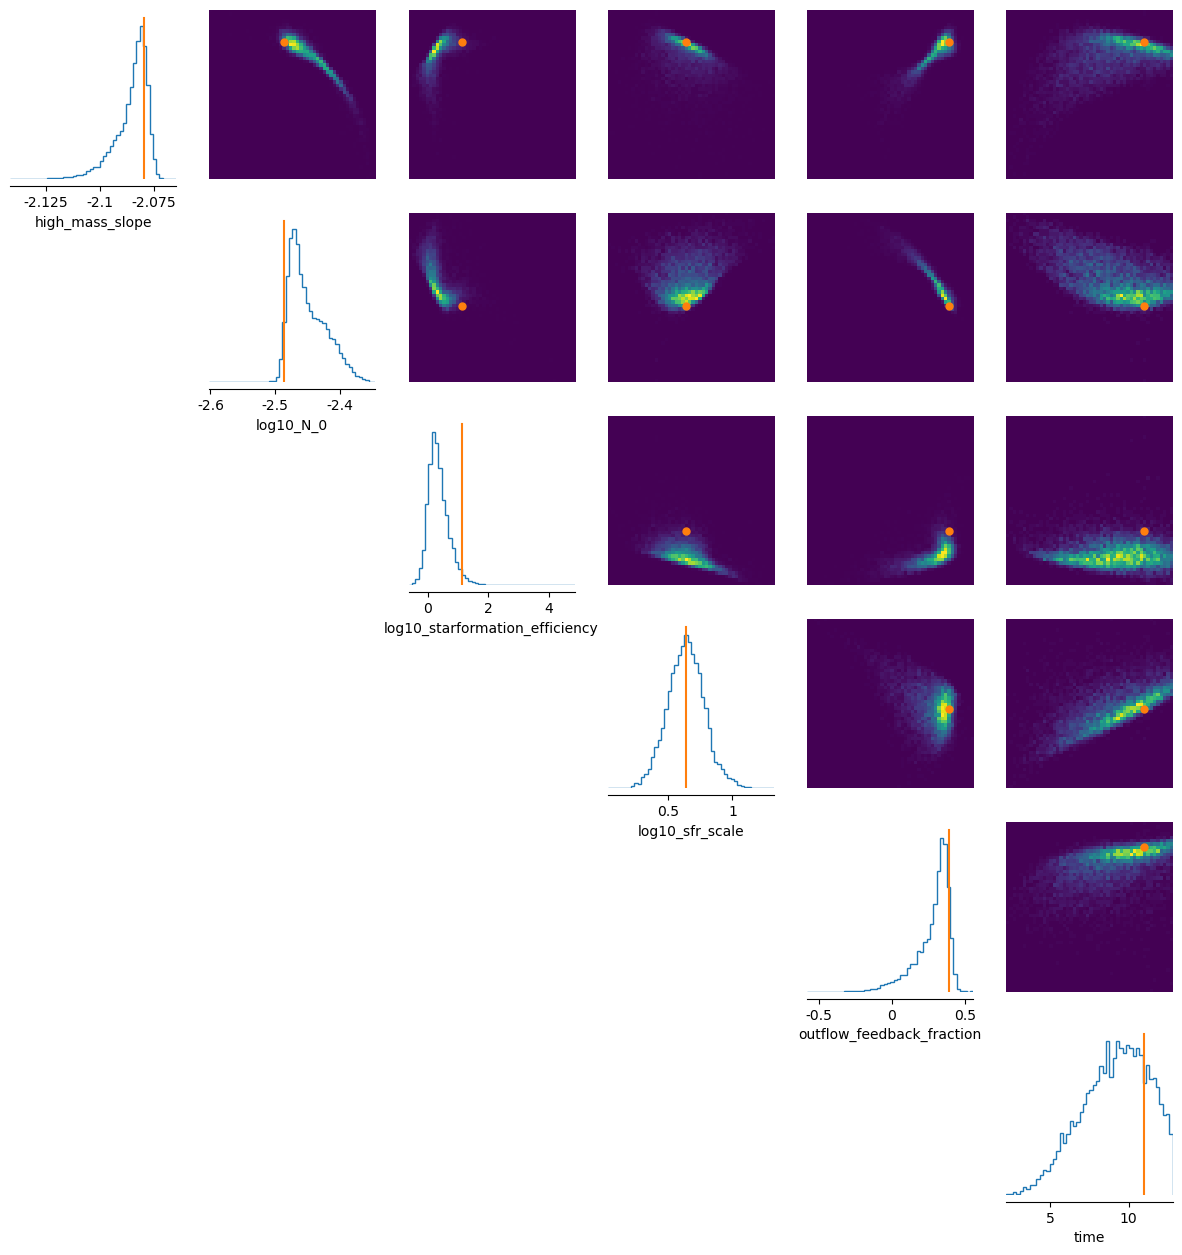

In [118]:
index = np.random.randint(0, len(val_x))
x = val_x[index]
y = val_y[index]

print(f'Index: {index}')
print(f'x: {x}')
posterior_samples = posterior.sample((10000,), x=y)
_ = pairplot(posterior_samples, figsize=(15, 15), points=x, labels=labels)


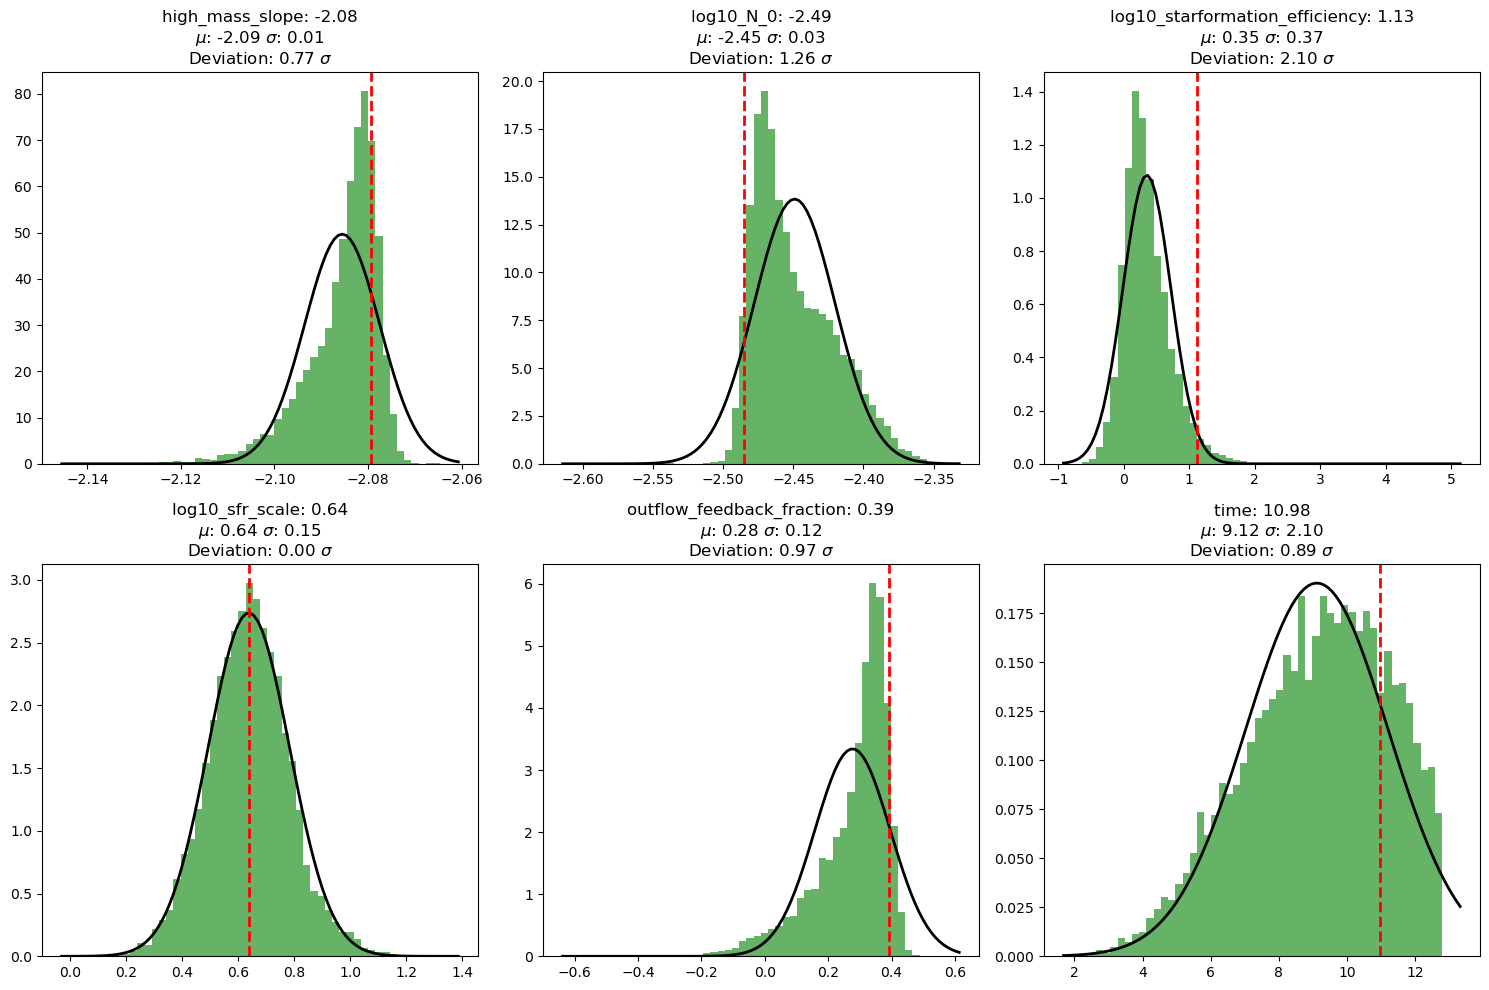

In [119]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))

for i in range(6):
    
    (mu, sigma) = norm.fit(posterior_samples.numpy().T[i])
    true_value = val_x[index][i].numpy()

    deviation = abs(true_value - mu) / sigma
    
    ax[i//3, i%3].hist(posterior_samples.numpy().T[i], bins=50, density=True, alpha=0.6, color='g')
    xmin, xmax = ax[i//3, i%3].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    ax[i//3, i%3].plot(x, p, 'k', linewidth=2)
    ax[i//3, i%3].axvline(x=true_value, color='r', linestyle='dashed', linewidth=2)
    
    ax[i//3, i%3].set_title(fr"{labels[i]}: {true_value:.2f}"
                            "\n"
                            fr"$\mu$: {mu:.2f} $\sigma$: {sigma:.2f}"
                            "\n"
                            fr"Deviation: {deviation:.2f} $\sigma$")
    
plt.tight_layout()
plt.show()

In [115]:
print("Priors:")
for i in range(len(priors)):
    print(fr'{labels[i]}: {priors[i][0].item():.2f} +/- {priors[i][1].item():.2f}')

Priors:
high_mass_slope: -2.30 +/- 0.30
log10_N_0: -2.89 +/- 0.30
log10_starformation_efficiency: -0.30 +/- 0.30
log10_sfr_scale: 0.55 +/- 0.10
outflow_feedback_fraction: 0.50 +/- 0.10


In [153]:
# Evaluate the fit of the posterior on the validation data
mu = []
sigma = []
deviation = []

# evaluate 100 random samples from the validation data
val_set = np.random.choice(len(val_x), 100, replace=False)

start = t.time()
run = 0
for i in val_set:
    x = val_x[i]
    y = val_y[i]
    posterior_samples = posterior.sample((10000,), x=y)
    
    mu_ = []
    sigma_ = []
    deviation_ = []
    for j in range(6):
        (mu__, sigma__) = norm.fit(posterior_samples.numpy().T[j])
        true_value = x[j].numpy()
        deviation__ = abs(true_value - mu__) / sigma__
        
        mu_.append(mu__)
        sigma_.append(sigma__)
        deviation_.append(deviation__)
        
    mu.append(mu_)
    sigma.append(sigma_)
    deviation.append(deviation_)
    
    clear_output()
    run += 1
    print(f"Evaluated {run}/{len(val_set)} samples in {round(t.time() - start, 1)}s")

end = t.time()
print(f'Time taken to evaluate the posterior on the validation data: {round(end - start, 4)}s')

Evaluated 13/100 samples in 4.1s


ValueError: I/O operation on closed file

In [ ]:
mu = np.array(mu)
sigma = np.array(sigma)
deviation = np.array(deviation)

np.savez('data/posterior_evaluation.npz', mu=mu, sigma=sigma, deviation=deviation)

In [ ]:
# fit the deviation to a normal distribution
fig, ax = plt.subplots(2,3, figsize=(15, 10))

for i in range(6):
    (mu, sigma) = norm.fit(deviation[:, i])
    x = np.linspace(0, 5, 100)
    p = norm.pdf(x, mu, sigma)
    
    ax[i//3, i%3].hist(deviation[:, i], bins=50, density=True, alpha=0.6, color='g')
    ax[i//3, i%3].plot(x, p, 'k', linewidth=2)
    ax[i//3, i%3].set_title(fr"{labels[i]}: $\mu$: {mu:.2f} $\sigma$: {sigma:.2f}")
    
plt.tight_layout()
plt.show()